# Calculator mode
Although CCL can generate basic cosmological quantities (background expansion, linear and non-linear matter power spectra) from a set of cosmological parameters, it is also possible to ingest those from an external code (e.g. `hi_class` if you're interested in modified gravity), and process them into more complex observables (shear power spectra, cluster number counts, halo model power spectra...). This notebook demonstrates how to do that.

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

Let's start by loading CLASS, which we'll use to generate background quantities and power spectra.

In [2]:
import classy

Now let's compute a few quantities from CLASS for the following cosmological parameters: $\Omega_c=0.25$, $\Omega_b=0.05$, $h=0.67$, $A_s=2.4\times10^{-9}$, $n_s=0.96$.

In [3]:
Omega_c = 0.25
Omega_b = 0.05
h = 0.67
A_s = 2.4E-9
n_s = 0.96


params = {
    "output": "mPk",
    "P_k_max_1/Mpc": 50.,
    "z_max_pk": 99,
    "modes": "s",
    "lensing": "no",
    "h": h,
    "Omega_cdm": Omega_c,
    "Omega_b": Omega_b,
    "Omega_k": 0.,
    "n_s": n_s,
    "N_ur": 3.046,
    "T_cmb": 2.725,
    "A_s": A_s,
    "non linear": "halofit"
}
model = classy.Class()
model.set(params)
model.compute()

Let's now calculate distances, expansion rate and power spectra

In [4]:
# Background
bg = model.get_background()
a_bg = 1/(1+bg['z'])
msk = a_bg > 0.002
a_bg = a_bg[msk]
# Distances
chi = bg['comov. dist.'][msk]
# Expansion rate
h_over_h0 = bg['H [1/Mpc]'][msk]
h_over_h0 /= h_over_h0[-1]

# Power spectra
k_arr = np.logspace(-5., np.log10(49.), 200)
nk = len(k_arr)
a_arr = np.linspace(0.1, 1., 100)
# Linear
pkln = np.array([[model.pk_lin(k, 1./a-1)
                  for k in k_arr]
                 for a in a_arr])
# non-linear
pknl = np.array([[model.pk(k, 1./a-1)
                  for k in k_arr]
                 for a in a_arr])

OK! Now let's create a `CosmologyCalculator` object. These objects take, as input, a set of cosmological parameters, as well as arrays containing background quantities (comoving distance and expansion rate), linear, and non-linear power spectra

In [5]:
cosmo_cal = ccl.CosmologyCalculator(Omega_c=Omega_c, Omega_b=Omega_b, h=h, A_s=A_s, n_s=n_s,
                                    background={'a': a_bg, 'chi': chi, 'h_over_h0': h_over_h0},
                                    pk_linear={'a': a_arr, 'k': k_arr,
                                               'delta_matter:delta_matter': pkln},
                                    pk_nonlin={'a': a_arr, 'k': k_arr,
                                               'delta_matter:delta_matter': pknl})

Note that, when passing power spectrum information, you define the power spectrum as `delta_matter:delta_matter`. `Cosmology` objects can in fact store an arbitrary number of power spectra between pairs of quantities. Currently the only useful one is the matter overdensity power spectrum, but this will change in the future.

Let's also create a standard `Cosmology` object for reference.

In [6]:
cosmo_ref = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, A_s=A_s, n_s=n_s,
                          transfer_function='boltzmann_class')

Now let's compare some quantities calculated with both objects. We will do distances, $P(k)$s and $C_\ell$s.

In [7]:
zs = np.linspace(0., 1.5, 128)
chi1 = ccl.comoving_radial_distance(cosmo_cal, 1./(1+zs))
chi2 = ccl.comoving_radial_distance(cosmo_ref, 1./(1+zs))

ks = np.geomspace(1E-3, 3., 128)
pkln1 = ccl.linear_matter_power(cosmo_cal, ks, 1./(1+0.2))
pkln2 = ccl.linear_matter_power(cosmo_ref, ks, 1./(1+0.2))

ks = np.geomspace(1E-3, 3., 128)
pknl1 = ccl.nonlin_matter_power(cosmo_cal, ks, 1./(1+0.2))
pknl2 = ccl.nonlin_matter_power(cosmo_ref, ks, 1./(1+0.2))

ls = np.unique(np.geomspace(2, 2000, 128).astype(int)).astype(float)
znz = np.linspace(0., 1., 1024)
nnz = np.exp(-0.5*((znz-0.5)/0.05)**2)
t1 = ccl.WeakLensingTracer(cosmo_cal, (znz, nnz))
t2 = ccl.WeakLensingTracer(cosmo_ref, (znz, nnz))
cl1 = ccl.angular_cl(cosmo_cal, t1, t1, ls)
cl2 = ccl.angular_cl(cosmo_ref, t2, t2, ls)


[]

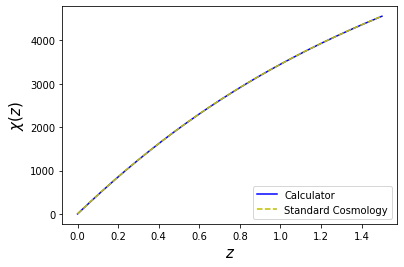

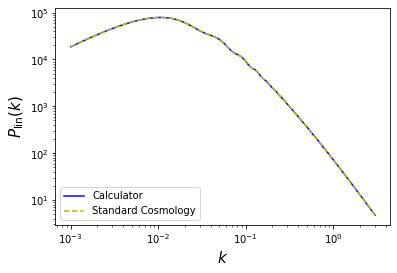

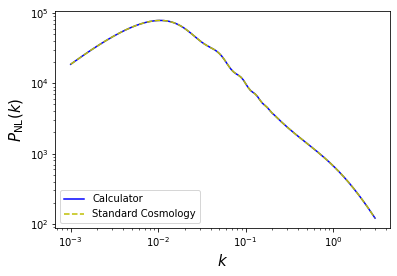

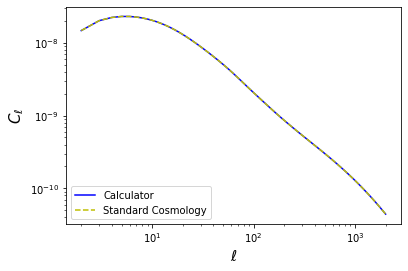

In [8]:
plt.figure()
plt.plot(zs, chi1, 'b-', label='Calculator')
plt.plot(zs, chi1, 'y--', label='Standard Cosmology')
plt.legend(loc='lower right')
plt.xlabel(r'$z$', fontsize=15)
plt.ylabel(r'$\chi(z)$', fontsize=15);

plt.figure()
plt.plot(ks, pkln1, 'b-', label='Calculator')
plt.plot(ks, pkln2, 'y--', label='Standard Cosmology')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P_{\rm lin}(k)$', fontsize=15)
plt.legend(loc='lower left')
plt.loglog()

plt.figure()
plt.plot(ks, pknl1, 'b-', label='Calculator')
plt.plot(ks, pknl2, 'y--', label='Standard Cosmology')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel(r'$P_{\rm NL}(k)$', fontsize=15)
plt.legend(loc='lower left')
plt.loglog()

plt.figure()
plt.plot(ls, cl1, 'b-', label='Calculator')
plt.plot(ls, cl2, 'y--', label='Standard Cosmology')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(loc='lower left')
plt.loglog()
